In [1]:
import ssdeep
import pickle,os,sys
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter

In [2]:
df = pd.read_parquet('/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7_1.parquet')
pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
df['tcp_payload_avg'] = df.tcp_payload_size/df.session_packets
df['udp_payload_size'] = df.udp_length_sum - (df.session_packets*8)
df['udp_payload_avg'] = df.udp_payload_size/df.session_packets
df['icmp_payload_avg'] = df.icmp_length_original_datagram_sum/df.session_packets
# df
print(df.columns) # 讀近來max需要90GB、讀完以後60GB
df

Index(['frame_time', 'frame_time_list', 'session_duration', 'session_packets',
       'tcp_window_size_value_avg', 'tcp_window_size_value_max',
       'tcp_payload_size', 'tcp_hdr_len_sum', 'icmp_length_sum',
       'icmp_length_original_datagram_sum', 'tcp_srcport', 'tcp_dstport',
       'tcp_flags_ack', 'tcp_flags_fin', 'tcp_flags_push', 'tcp_flags_reset',
       'tcp_flags_syn', 'ip_src', 'ip_dst', 'ip_ttl_avg', 'ip_ttl_max',
       'ip_proto', 'frame_protocols_common', 'frame_protocols_max',
       'frame_len_sum', 'country', 'city', 'subdivisions', 'latitude',
       'longitude', 'domain', 'isp', 'network', 'udp_length_sum',
       'udp_srcport', 'udp_dstport', 'tcp_payload_list', 'tcp_payload_avg',
       'udp_payload_size', 'udp_payload_avg', 'icmp_payload_avg'],
      dtype='object')


,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
0,1.578631e+09,"[1578631184.340402, 1578631184.340767, 1578631...",0.577366,4,8192.000000,8192.0,0.0,104.0,NaN,NaN,56932.0,445.0,2.0,0.0,0.0,2.0,2.0,1.0.186.181,210.242.146.160,46.0,46.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,252,Thailand,Rayong,Changwat Rayong,12.6667,101.2833,totbroadband.com,TOT,1.0.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN,NaN
1,1.578625e+09,"[1578625336.766491, 1578625336.766719]",0.000228,2,8192.000000,8192.0,0.0,52.0,NaN,NaN,27768.0,445.0,1.0,0.0,0.0,1.0,1.0,1.1.207.16,210.242.146.202,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,126,Thailand,Udon Thani,Changwat Udon Thani,17.135,102.972,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN,NaN
2,1.578638e+09,[1578637601.800759],0.000000,1,8192.000000,8192.0,0.0,32.0,NaN,NaN,54303.0,445.0,0.0,0.0,0.0,0.0,1.0,1.1.208.143,210.242.145.64,110.0,110.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,66,Thailand,Loei,Changwat Loei,17.4833,101.7167,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN,NaN
3,1.578638e+09,"[1578637614.315572, 1578637614.315848, 1578637...",0.089143,6,13862.666667,16698.0,88.0,144.0,NaN,NaN,56911.0,445.0,5.0,0.0,1.0,1.0,2.0,1.1.208.143,210.242.145.68,110.0,110.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,448,Thailand,Loei,Changwat Loei,17.4833,101.7167,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1X...,14.666667,NaN,NaN,NaN
4,1.578637e+09,[1578637160.937851],0.000000,1,8192.000000,8192.0,0.0,32.0,NaN,NaN,65301.0,445.0,0.0,0.0,0.0,0.0,1.0,1.1.208.143,210.242.145.9,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,66,Thailand,Loei,Changwat Loei,17.4833,101.7167,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41508125,1.578622e+09,"[1578622286.465953, 1578622286.46626, 15786222...",1.044850,15,4371.142857,29200.0,1110.0,496.0,NaN,NaN,55834.0,22.0,14.0,2.0,5.0,0.0,2.0,99.185.76.161,210.242.145.250,48.0,48.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:ssh,2116,United States,Columbia,South Carolina,34.0853,-80.9167,sbcglobal.net,AT&T U-verse,99.185.72.0/21,NaN,NaN,NaN,[3:DfQMPmflfTAfQW4Y7wUY6ljrA6EkvA6HfQNun:DPQl2...,74.000000,NaN,NaN,NaN
41508126,1.578588e+09,"[1578588469.32971, 1578588469.330028]",0.000318,2,14600.000000,14600.0,0.0,40.0,NaN,NaN,60765.0,9000.0,1.0,0.0,0.0,1.0,1.0,99.39.181.123,210.242.147.172,238.0,238.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,114,United States,Benton Harbor,Michigan,42.1098,-86.4259,sbcglobal.net,AT&T U-verse,99.39.180.0/22,NaN,NaN,NaN,[],0.000000,NaN,NaN,NaN
41508127,1.578591e+09,[1578590800.561657],0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.47.1.89,210.242.147.18,NaN,NaN,1,eth:ethertype:ip:icmp:ip:udp:data,eth:ethertype:ip:icmp:ip:udp:data,582,United States,Los Angeles,California,34.118,-118.3303,None,AT&T Internet Services,99.47.1.0/24,520.0,20967.0,39122.0,[],NaN,512.0,512.0,NaN
41508128,1.578620e+09,"[1578619766.68774, 1578619766.688091, 15786197...",3.368423,4,5840.000000,5840.0,0.0,92.0,NaN,NaN,56131.0,80.0,3.0,0.0,0.0,0.0,4.0,99.75.17.232,210.242.147.149,238.0,238.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,234,United States,Oceanside,California,33.1955,-117.2862,sbcglobal.net,AT&T U-verse,99.75.16.0/21,NaN,NaN,NaN,[],

In [4]:
stat_all = df[(df.tcp_payload_size>0)|(df.udp_payload_size>0)|(df.icmp_length_original_datagram_sum>0)]
print(stat_all.frame_protocols_max.value_counts(dropna=False).head(60)
      ,len(stat_all.frame_protocols_max.value_counts()))
stat_all

eth:ethertype:ip:tcp:tds:gss-api                        12803013
eth:ethertype:ip:tcp:tds                                 2870272
eth:ethertype:ip:tcp:nbss:smb                            1079549
eth:ethertype:ip:tcp:ssh                                  393062
eth:ethertype:ip:tcp:data                                 344939
eth:ethertype:ip:udp:data                                 248979
eth:ethertype:ip:udp:sip:sdp                              236691
eth:ethertype:ip:tcp:http:data-text-lines                 150989
eth:ethertype:ip:tcp:nbss:smb:smb:smb                     108768
eth:ethertype:ip:udp:sip                                  108323
eth:ethertype:ip:tcp:http                                  77458
eth:ethertype:ip:icmp:ip:udp:data                          69313
eth:ethertype:ip:tcp:nbss:smb:gss-api:spnego:ntlmssp       66146
eth:ethertype:ip:tcp                                       58542
eth:ethertype:ip:tcp:http:data                             41152
eth:ethertype:ip:udp:ssdp

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
3,1.578638e+09,"[1578637614.315572, 1578637614.315848, 1578637...",0.089143,6,13862.666667,16698.0,88.0,144.0,NaN,NaN,56911.0,445.0,5.0,0.0,1.0,1.0,2.0,1.1.208.143,210.242.145.68,110.0,110.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,448,Thailand,Loei,Changwat Loei,17.4833,101.7167,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1X...,14.666667,NaN,NaN,NaN
5,1.578619e+09,"[1578619478.949301, 1578619478.949503, 1578619...",0.083323,6,13775.333333,16567.0,137.0,144.0,NaN,NaN,32670.0,445.0,5.0,0.0,1.0,1.0,2.0,1.1.219.197,210.242.147.116,110.0,110.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,497,Thailand,Surin,Changwat Surin,14.8818,103.4936,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,22.833333,NaN,NaN,NaN
6,1.578656e+09,"[1578656074.938036, 1578656074.9382, 157865607...",0.101331,6,45930.666667,64800.0,137.0,136.0,NaN,NaN,54403.0,445.0,5.0,0.0,1.0,1.0,2.0,1.10.132.97,210.242.146.115,46.0,46.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,489,Thailand,Bangkok,Bangkok,13.7366,100.4995,totinternet.net,TOT,1.10.128.0/17,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,22.833333,NaN,NaN,NaN
7,1.578656e+09,"[1578656082.436195, 1578656082.436429, 1578656...",120.416351,16,57603.250000,64800.0,596.0,336.0,NaN,NaN,55233.0,445.0,15.0,2.0,7.0,0.0,2.0,1.10.132.97,210.242.146.118,46.0,46.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,1500,Thailand,Bangkok,Bangkok,13.7366,100.4995,totinternet.net,TOT,1.10.128.0/17,NaN,NaN,NaN,[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1X...,37.250000,NaN,NaN,NaN
9,1.578644e+09,"[1578643889.235047, 1578643889.235189, 1578643...",0.103711,6,2903.333333,8192.0,137.0,144.0,NaN,NaN,60100.0,445.0,5.0,0.0,1.0,1.0,2.0,1.10.162.226,210.242.146.117,109.0,109.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,497,Thailand,Udon Thani,Changwat Udon Thani,17.135,102.972,totinternet.net,TOT,1.10.128.0/17,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,22.833333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41508114,1.578622e+09,"[1578621770.33071, 1578621770.33098, 157862177...",0.219120,6,3072.666667,8192.0,41.0,144.0,NaN,NaN,63762.0,1433.0,5.0,0.0,1.0,1.0,2.0,98.102.230.62,210.242.146.101,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,401,United States,Logan,Ohio,39.5372,-82.4126,rr.com,Spectrum Business,98.102.224.0/20,NaN,NaN,NaN,[3:OfVGXK9fV1V1V1V1UQ91BVWfg0VZ39CVRfHfVYN1V1V...,6.833333,NaN,NaN,NaN
41508115,1.578625e+09,"[1578625056.688546, 1578625056.688709, 1578625...",0.208208,6,3072.666667,8192.0,41.0,144.0,NaN,NaN,55463.0,1433.0,5.0,0.0,1.0,1.0,2.0,98.102.230.62,210.242.146.112,111.0,111.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,401,United States,Logan,Ohio,39.5372,-82.4126,rr.com,Spectrum Business,98.102.224.0/20,NaN,NaN,NaN,[3:OfVGXK9fV1V1V1V1UQ91BVWfg0VZ39CVRfHfVYN1V1V...,6.833333,NaN,NaN,NaN
41508118,1.578620e+09,"[1578619630.262857, 1578619630.263198, 1578619...",0.158426,6,45557.333333,64240.0,214.0,136.0,NaN,NaN,53655.0,1433.0,5.0,0.0,1.0,1.0,2.0,98.126.151.154,210.242.148.102,115.0,115.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,568,United States,Sacramento,California,38.6415,-121.5114,krypt.com,Krypt Technologies,98.126.0.

In [5]:
19179078/41508130

0.4620559394027146

In [20]:
format(494/19724900,'f')

'0.000025'

In [19]:
stat_all[stat_all.frame_protocols_max.str.contains('telnet')]

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
1858,1.578592e+09,"[1578591522.229824, 1578591522.230147, 1578591...",15.704731,13,1049.375000,5840.0,66.0,480.0,NaN,NaN,38325.0,23.0,11.0,0.0,3.0,1.0,5.0,101.108.36.122,210.242.146.54,45.0,45.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,994,Thailand,Saraburi,Changwat Saraburi,14.7167,100.8,totinternet.net,TOT,101.108.0.0/15,NaN,NaN,NaN,"[3:cRm5tD+U/Y7EDdvEdn:rHKAqEDxgn, 3:cRm5tD+U/Y...",5.076923,NaN,NaN,NaN
19156,1.578645e+09,"[1578644592.620193, 1578644595.613457, 1578644...",32.825027,16,1581.666667,5840.0,70.0,556.0,NaN,NaN,50506.0,23.0,14.0,2.0,3.0,0.0,4.0,125.26.159.177,210.242.149.33,45.0,45.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1170,Thailand,Ayutthaya,Phra Nakhon Si Ayutthaya,14.3738,100.5631,totinternet.net,TOT,125.26.0.0/15,NaN,NaN,NaN,"[3:cRm5tD+U/Y7EDdvEdn:rHKAqEDxgn, 3:Qi1MRha5b/...",4.375000,NaN,NaN,NaN
135514,1.578647e+09,"[1578646736.469245, 1578646736.469487, 1578646...",23.759432,21,2101.071429,26883.0,69.0,712.0,NaN,NaN,47952.0,23.0,19.0,1.0,8.0,1.0,5.0,54.153.91.4,210.242.147.11,39.0,39.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1495,United States,San Jose,California,37.3388,-121.8914,amazonaws.com,Amazon,54.153.0.0/16,NaN,NaN,NaN,[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn],3.285714,NaN,NaN,NaN
224681,1.578647e+09,"[1578647418.81365, 1578647419.832348, 15786474...",16.855490,15,5524.300000,26883.0,51.0,500.0,NaN,NaN,52886.0,23.0,12.0,1.0,5.0,1.0,4.0,13.57.246.146,210.242.145.57,40.0,40.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1061,United States,San Jose,California,37.3388,-121.8914,amazonaws.com,Amazon.com,13.56.0.0/14,NaN,NaN,NaN,[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn],3.400000,NaN,NaN,NaN
327214,1.578647e+09,"[1578647301.22184, 1578647302.226522, 15786473...",30.028692,20,3767.266667,26883.0,48.0,676.0,NaN,NaN,58758.0,23.0,17.0,3.0,8.0,1.0,6.0,34.220.212.39,210.242.146.40,39.0,39.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1410,United States,Boardman,Oregon,45.8491,-119.7143,amazonaws.com,Amazon.com,34.208.0.0/12,NaN,NaN,NaN,[],2.400000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41079662,1.578646e+09,"[1578645843.37125, 1578645846.375209, 15786458...",16.350389,8,160.000000,200.0,74.0,196.0,NaN,NaN,65409.0,23.0,6.0,0.0,2.0,1.0,3.0,92.119.160.30,210.242.145.13,117.0,117.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,548,Russia,None,None,55.7386,37.6068,None,Mosnet LLC,92.119.160.0/24,NaN,NaN,NaN,[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/2v...,9.250000,NaN,NaN,NaN
41154429,1.578671e+09,"[1578671036.315821, 1578671036.316124, 1578671...",20.126711,17,200.000000,200.0,329.0,436.0,NaN,NaN,61686.0,23.0,15.0,0.0,7.0,1.0,5.0,194.61.24.75,210.242.148.24,102.0,102.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1349,Netherlands,Amsterdam,North Holland,52.371,4.9041,None,ERA LLC,194.61.24.0/23,NaN,NaN,NaN,[3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/2v...,19.352941,NaN,NaN,NaN
41303729,1.578670e+09,"[1578669888.283107, 1578669889.281269, 1578669...",27.214514,19,4367.714286,29200.0,336.0,644.0,NaN,NaN,59402.0,23.0,16.0,4.0,7.0,1.0,6.0,107.6.169.250,210.242.149.59,52.0,52.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,1632,Netherlands,Amsterdam,North Holland,52.2832,4.7521,stablehost.com,SingleHop LLC,107.6.128.0/18,NaN,NaN,NaN,[3:PX6gX9/B91XV1UV9K

In [154]:
stat_all.frame_protocols_max.value_counts(dropna=False).index

Index(['eth:ethertype:ip:tcp:tds:gss-api', 'eth:ethertype:ip:tcp:tds',
       'eth:ethertype:ip:tcp:nbss:smb', 'eth:ethertype:ip:tcp:ssh',
       'eth:ethertype:ip:tcp:data', 'eth:ethertype:ip:udp:sip:sdp',
       'eth:ethertype:ip:tcp:http:data-text-lines',
       'eth:ethertype:ip:udp:data', 'eth:ethertype:ip:tcp:nbss:smb:smb:smb',
       'eth:ethertype:ip:udp:sip',
       ...
       'eth:ethertype:ip:udp:teredo:data',
       'eth:ethertype:ip:icmp:ip:udp:llc:data',
       'eth:ethertype:ip:udp:bat:data', 'eth:ethertype:ip:icmp:ip:tcp:http',
       'eth:ethertype:ip:icmp:ip:udp:lwapp:data',
       'eth:ethertype:ip:icmp:ip:udp:dpnet',
       'eth:ethertype:ip:udp:corosync_totemnet:data',
       'eth:ethertype:ip:icmp:ip:udp:ipvs', 'eth:ethertype:ip:udp:rsvp',
       'eth:ethertype:ip:udp:egd'],
      dtype='object', length=336)

In [156]:
for i in stat_all.frame_protocols_max.value_counts(dropna=False).index:#.head(105)
    if i == 'eth:ethertype:ip:tcp':
        print(i)

eth:ethertype:ip:tcp


In [87]:
one = df[(df.tcp_payload_size>0)|(df.udp_payload_size>0)]
two = one[one.frame_protocols_max=='eth:ethertype:ip:udp']
two

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
5164,1.578618e+09,[1578618108.100195],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.190.41.191,210.242.149.73,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,100,China,Guang'an,Sichuan,30.4741,106.637,None,China Telecom,110.190.0.0/16,66.0,9928.0,1900.0,[],NaN,58.0,58.0,NaN
90772,1.578633e+09,[1578633123.900763],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.149.156.82,210.242.146.131,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,63,China,Huaihua,Hunan,27.5494,109.9592,None,China Telecom,223.144.0.0/12,29.0,37697.0,1900.0,[],NaN,21.0,21.0,NaN
222758,1.578666e+09,[1578665965.575353],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.67.89.74,210.242.145.115,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,76,China,None,Inner Mongolia Autonomous Region,40.6522,109.8222,None,China Unicom Liaoning,124.67.88.0/22,42.0,1900.0,5353.0,[],NaN,34.0,34.0,NaN
297979,1.578627e+09,[1578626943.756271],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.149.246.15,210.242.146.29,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,89,China,Huaihua,Hunan,27.5494,109.9592,None,China Telecom,223.144.0.0/12,55.0,30178.0,1900.0,[],NaN,47.0,47.0,NaN
413364,1.578617e+09,[1578616704.060993],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.246.222.69,210.242.148.164,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,121,South Korea,Cheongju-si,North Chungcheong,36.6349,127.4706,None,SK Broadband,1.246.0.0/16,87.0,1900.0,30301.0,[],NaN,79.0,79.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40822563,1.578620e+09,[1578620262.602371],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.43.194.219,210.242.145.104,39.0,39.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,74,Russia,Solikamsk,Perm Krai,59.6433,56.75,perm.ru,MTS PJSC,77.43.192.0/18,40.0,1900.0,30301.0,[],NaN,32.0,32.0,NaN
41097471,1.578639e+09,[1578639094.995195],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.59.18.131,210.242.145.203,51.0,51.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,114,China,Anyang,Henan,36.1386,114.1066,None,China Unicom Liaoning,115.48.0.0/12,80.0,1027.0,1900.0,[],NaN,72.0,72.0,NaN
41299871,1.578604e+09,[1578604273.620765],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.246.223.109,210.242.148.229,50.0,50.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,102,South Korea,Cheongju-si,North Chungcheong,36.6349,127.4706,None,SK Broadband,1.246.0.0/16,68.0,1900.0,8082.0,[],NaN,60.0,60.0,NaN
41305042,1.578635e+09,[1578634983.984611],0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.40.111.202,210.242.146.179,46.0,46.0,17,eth:ethertype:ip:udp,eth:ethertype:ip:udp,72,China,Jixi,Heilongjiang,45.3011,130.9572,None,China Mobile Guangdong,111.40.0.0/14,38.0,8081.0,1900.0,[],NaN,30.0,30.0,NaN


In [159]:
len(df)

50232666

In [158]:
58844/len(df)

0.0011714289661631735

In [92]:
case_1 = stat_all[stat_all.frame_protocols_max.str.contains('http')]
case_1

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg
31,1.578656e+09,"[1578656455.319332, 1578656455.320039, 1578656...",0.015395,6,13862.666667,16698.0,135.0,144.0,NaN,NaN,60653.0,80.0,5.0,0.0,1.0,1.0,2.0,1.163.117.128,210.242.149.66,120.0,120.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,495,Taiwan,Taoyuan District,Taoyuan,24.9889,121.3176,hinet.net,HiNet,1.160.0.0/12,NaN,NaN,NaN,[6:uumYlloZOHKAqEiTBHE7T42pAy6A5gUA7i+stfXpUeF...,22.500000,NaN,NaN
69,1.578658e+09,"[1578657581.553342, 1578657581.553574, 1578657...",0.011384,6,13770.666667,16560.0,135.0,144.0,NaN,NaN,13045.0,80.0,5.0,0.0,1.0,1.0,2.0,1.165.25.63,210.242.146.86,57.0,57.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,495,Taiwan,Yuanlin,Changhua,23.9611,120.5721,hinet.net,HiNet,1.160.0.0/12,NaN,NaN,NaN,[6:uumYlloZOHKAqEiTBHE7T42pAy6A5gUA7i+stfXpUeF...,22.500000,NaN,NaN
81,1.578663e+09,"[1578663142.807738, 1578663142.807961, 1578663...",0.007480,6,13770.666667,16560.0,135.0,144.0,NaN,NaN,4463.0,80.0,5.0,0.0,1.0,1.0,2.0,1.165.25.63,210.242.148.81,57.0,57.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,495,Taiwan,Yuanlin,Changhua,23.9611,120.5721,hinet.net,HiNet,1.160.0.0/12,NaN,NaN,NaN,[6:uumYlloZOHKAqEiTBHE7T42pAy6A5gUA7i+stfXpUeF...,22.500000,NaN,NaN
86,1.578666e+09,"[1578666333.571906, 1578666333.572236, 1578666...",11.706569,16,15862.666667,16560.0,1080.0,392.0,NaN,NaN,11197.0,80.0,14.0,0.0,8.0,1.0,4.0,1.165.25.63,210.242.149.21,57.0,57.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,2022,Taiwan,Yuanlin,Changhua,23.9611,120.5721,hinet.net,HiNet,1.160.0.0/12,NaN,NaN,NaN,[12:qYllIOHXqLHHUA+5UZFulExmMReT8C7Sm:qgllajHU...,67.500000,NaN,NaN
88,1.578665e+09,"[1578665171.31532, 1578665171.315494, 15786651...",0.064204,10,14877.200000,16560.0,225.0,224.0,NaN,NaN,4664.0,80.0,9.0,2.0,3.0,0.0,2.0,1.165.25.63,210.242.149.71,57.0,57.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,801,Taiwan,Yuanlin,Changhua,23.9611,120.5721,hinet.net,HiNet,1.160.0.0/12,NaN,NaN,NaN,[6:uumYlloZOHKAqEiTBHE7T42pAy6A5gUA7i+stfXpUeF...,22.500000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50232137,1.578606e+09,"[1578606415.234694, 1578606415.234906, 1578606...",1.096912,10,2389.600000,5840.0,678.0,336.0,NaN,NaN,4789.0,80.0,9.0,2.0,3.0,0.0,2.0,94.89.40.90,210.242.149.75,49.0,49.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines:xml,1354,Italy,None,None,43.1479,12.1097,telecomitalia.it,Telecom Italia Business,94.88.0.0/15,NaN,NaN,NaN,[12:DC779Xdykq16Bn6R7o6sD/XmHXqrI2ErB5cuXNQNcx...,67.800000,NaN,NaN
50232265,1.578650e+09,"[1578649949.821478, 1578649949.821769, 1578649...",0.246065,6,9886.000000,29200.0,95.0,208.0,NaN,NaN,58150.0,443.0,5.0,0.0,1.0,1.0,2.0,95.213.244.42,210.242.145.85,54.0,54.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,507,Russia,None,None,55.7386,37.6068,None,OOO Network of data-centers Selectel,95.213.244.0/23,NaN,NaN,NaN,[6:4nKN6SRIsTgeRVMHKAqEDxgb6SRIsTgeTBfuHy6A5SK...,15.833333,NaN,NaN
50232275,1.578608e+09,"[1578607824.151362, 1578607824.1516, 157860782...",1.056652,12,2814.166667,14600.0,114.0,400.0,NaN,NaN,59406.0,80.0,11.0,2.0,4.0,0.0,2.0,95.238.191.243,210.242.148.121,48.0,48.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,922,Italy,Cinquevie,Naples,40.8809,14.5280,telecomitalia.it,Telecom Italia,95.232.0.0/13,NaN,NaN,NaN,"[3:cRm5tD+U/2:rHKA2, 3:KD+U/kakXbVfLu:KKAkakXU...",9.500000,NaN,NaN
50232562,1.

In [145]:
def knee_point(length_li,k=60):
    """
    length_li: 長度的list
    k: slope topK's knee points
    Return dict format (key is the answer)
    """
    length_dict = dict(Counter(length_li))
    sorted_dict = {k: v for k, v in sorted(length_dict.items(), key=lambda x: x[1])}
    all_items_num = sum(list(length_dict.values()))
#     for item in sorted_dict.items():
    all_keys = list(sorted_dict.keys())
    all_values = list(sorted_dict.values())
    slope_li = []
    for i in range(len(sorted_dict)):
        length1 = all_keys[i]
        try:
            length2 = all_keys[i+1]
        except IndexError:
            break
        value1 = sum(all_values[:i+1])
        value2 = sum(all_values[:i+2])
        slope = ((value2-value1)/all_items_num)/(length2-length1)
        slope_li.append(slope)
    change_rate_li = []
    for i in range(len(slope_li)):
        try:
            slope1 = slope_li[i]
            slope2 = slope_li[i+1]
        except IndexError:
            break
        change_rate_li.append(abs(slope2-slope1)) #陡變緩或是緩變陡的都一起算
    idx_li = sorted(range(len(change_rate_li)), key=lambda i: change_rate_li[i], reverse=True)[:k]
    return_dict = {}
    for idx in idx_li:
        return_dict[all_keys[idx+1]] = change_rate_li[idx]
    return pd.DataFrame.from_dict(return_dict,orient='index',columns=['knee_slope'])

In [76]:
try1 = case_1.session_duration.tolist()
knee_point(try1)

NameError: name 'case_1' is not defined

In [152]:
df.session_packets.describe()

count    5.023267e+07
mean     9.465586e+00
std      1.019801e+02
min      1.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      2.997000e+04
Name: session_packets, dtype: float64

In [ ]:
df.se

#### case7

In [21]:
df_fil2_http = df[df['frame_protocols_max'].str.contains('http')]
df_fil2_http = df_fil2_http[(df_fil2_http.domain != 'googlebot.com')&(df_fil2_http.isp!='Googlebot')]
print(len(df_fil2_http))
iqr = df_fil2_http['tcp_payload_avg'].quantile(0.75)-df_fil2_http['tcp_payload_avg'].quantile(0.25)
outlier = df_fil2_http['tcp_payload_avg'].quantile(0.75) + 3*iqr
df_fil32_http = df_fil2_http[df_fil2_http['tcp_payload_avg']>outlier]
df_fil32_http

189090


,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
168,1.578631e+09,"[1578630827.325076, 1578630827.325329, 1578630...",3.947571,69,2382.666667,14400.0,84852.0,2224.0,NaN,NaN,58936.0,80.0,68.0,0.0,11.0,1.0,2.0,1.2.169.8,210.242.148.183,244.000000,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,89422,Thailand,Samut Songkhram,Changwat Samut Songkhram,13.4,100.0,totinternet.net,TOT,1.2.128.0/17,NaN,NaN,NaN,[24:WAsU7Aaw9cOgUES18YH+w18YHxEMrw+MrqAsU5Nxdl...,1229.739130,NaN,NaN,NaN
2458,1.578631e+09,"[1578630825.243643, 1578630825.243877, 1578630...",3.096036,51,848.583333,14600.0,85635.0,1648.0,NaN,NaN,54091.0,80.0,50.0,0.0,16.0,1.0,2.0,103.140.207.218,210.242.149.186,50.000000,50.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,89017,Indonesia,None,None,-6.175,106.8286,None,PT Indonesia Comnets Plus,103.140.206.0/23,NaN,NaN,NaN,[24:WA1Aaw9cOFDdidS18YH+w18YHxEMgBP+MgBoEAIdlU...,1679.117647,NaN,NaN,NaN
2477,1.578646e+09,"[1578645539.872413, 1578645539.872709, 1578645...",8.184602,1338,4552.757377,14600.0,4492116.0,42832.0,NaN,NaN,33337.0,80.0,1337.0,2.0,35.0,0.0,2.0,103.16.71.248,210.242.149.153,47.996721,48.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,4580440,India,Bengaluru,Karnataka,12.9719,77.5937,None,Gatik Business Solutions,103.16.68.0/22,NaN,NaN,NaN,[48:+5v6ocd6z76H6V6zr36Wm6A6D6Q636z/6zF6L6z/6z...,3357.336323,NaN,NaN,NaN
2479,1.578606e+09,"[1578605578.670203, 1578605578.670507, 1578605...",3.046526,863,2633.137778,14600.0,3850109.0,27632.0,NaN,NaN,47229.0,80.0,862.0,2.0,85.0,0.0,2.0,103.16.71.248,210.242.149.153,47.991111,48.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,3907083,India,Bengaluru,Karnataka,12.9719,77.5937,None,Gatik Business Solutions,103.16.68.0/22,NaN,NaN,NaN,[48:+5p6G6K66gc6d6I6zz6y6G6J6SSB6ZaDw/+6kyXPSk...,4461.308227,NaN,NaN,NaN
3348,1.578659e+09,"[1578659123.786829, 1578659123.787033, 1578659...",1.377055,23,2569.416667,29200.0,42985.0,680.0,NaN,NaN,52640.0,80.0,16.0,0.0,3.0,7.0,2.0,103.50.160.20,210.242.145.138,53.000000,53.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,44447,India,None,None,20.0,77.0,None,PDR,103.50.160.0/22,NaN,NaN,NaN,[24:tAPg2kZ/LPUIEvt1GNYKP+9Cy9DjgMXSCYx:+3kFw1...,1868.913043,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41451137,1.578644e+09,"[1578644492.92055, 1578644492.920837, 15786444...",1.308716,36,1792.900000,29200.0,69710.0,1084.0,NaN,NaN,40650.0,80.0,28.0,0.0,5.0,8.0,2.0,71.6.232.9,210.242.148.183,52.000000,52.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,72018,United States,Henderson,Nevada,36.0119,-115.0433,None,CariNet,71.6.128.0/17,NaN,NaN,NaN,[12:rHXq6xmMRe4HIs0Kj51h6Y1awh5UP/VRIXNkZr1NkZ...,1936.388889,NaN,NaN,NaN
41451644,1.578594e+09,"[1578594077.192109, 1578594077.192419, 1578594...",5.544007,251,31681.125000,34560.0,365953.0,8040.0,NaN,NaN,36288.0,80.0,250.0,0.0,29.0,1.0,2.0,77.159.90.128,210.242.149.159,49.000000,49.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,382527,France,Bailleul-sur-Therain,Oise,49.3853,2.2228,sfr.net,SFR,77.156.0.0/14,NaN,NaN,NaN,[12:rHXq6xmMReT27fI/XES+AoGY1uqh5U9Z1J3vhm:Da7...,1457.980080,NaN,NaN,NaN
41454085,1.578607e+09,"[1578606842.946878, 1578606842.947162, 1578606...",0.846226,27,2069.866667,29200.0,37801.0,784.0,NaN,NaN,46203.0,80.0,18

In [22]:
outlier

1173.388888888889

In [113]:
df_fil2_http.tcp_payload_avg.describe()

count    189060.000000
mean        421.401021
std         693.040008
min           0.947368
25%          41.166667
50%          93.286364
75%         324.222222
max        6088.309220
Name: tcp_payload_avg, dtype: float64

In [94]:
df_fil32_http.session_packets.sum()

20795021

In [12]:
df_fil32_http.domain.value_counts().head(60)

linode.com                       422
no-reverse-dns-configured.com    346
cablecolor.hn                    344
convex-tagil.ru                  326
amazonaws.com                    299
alashadiorydshing.com            203
totinternet.net                  125
btv.lv                            90
prod-infinitum.com.mx             68
poneytelecom.eu                   68
telesp.net.br                     65
googleusercontent.com             61
violin.co.th                      60
asianet.co.th                     57
telecomitalia.it                  52
ttnet.com.tr                      49
vultr.com                         46
secureserver.net                  44
embratel.com.br                   39
ip-51-254-59.eu                   38
comcastbusiness.net               38
hwclouds-dns.com                  34
coloup.com                        31
hinet.net                         29
unifiedlayer.com                  26
grandenetworks.net                25
comcast.net                       24
1

In [111]:
len(df_fil32_http[df_fil32_http.domain == 'in.th'].ip_src.unique())

4

In [13]:
case7_df = df_fil32_http[(df_fil32_http.domain == 'cablecolor.hn') & (df_fil32_http.frame_protocols_max.str.contains("http")) & (df_fil32_http.tcp_payload_size >0)]
case7_df

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg
80767,1.578605e+09,"[1578604557.207698, 1578604557.207938, 1578604...",45.778904,1244,1765.471591,14600.0,3703381.0,39824.0,NaN,NaN,53244.0,80.0,1243.0,2.0,106.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,3785501,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQU6z76B5P6G6la6AA6D6Q6163A60ajSkhHvy/687...,2976.994373,NaN,NaN
332892,1.578611e+09,"[1578611372.995905, 1578611372.996146, 1578611...",5.275402,51,3018.777778,14600.0,70062.0,1648.0,NaN,NaN,34492.0,80.0,50.0,2.0,9.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,73444,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQi6V6K66gc616t6zz6y6G6GajSkhHvy/687/sQc:...,1373.764706,NaN,NaN
332894,1.578607e+09,"[1578607217.33231, 1578607217.332953, 15786072...",13.579636,965,8996.171756,19367.0,4115205.0,30896.0,NaN,NaN,44940.0,80.0,964.0,2.0,59.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,4178911,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQN6G6K66gc616d6zz6y6pajSkhHvy/687/sQc:+s...,4264.461140,NaN,NaN
332895,1.578648e+09,"[1578648288.693828, 1578648288.694201, 1578648...",6.470853,2235,22813.157312,24435.0,4537951.0,71536.0,NaN,NaN,46395.0,80.0,2234.0,2.0,50.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,4685477,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQT6c6z760uZ6G6zl6We6P6D6Q646z/6zF6K6z/6z...,2030.403132,NaN,NaN
332897,1.578648e+09,"[1578648398.4752, 1578648398.475409, 157864839...",7.415716,1071,13068.752508,23530.0,4539662.0,34288.0,NaN,NaN,49308.0,80.0,1070.0,2.0,61.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,4610364,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQ76H6z76z6G6zl6We6P6D6Q646z/6zF6K6z/6zF6...,4238.713352,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49560033,1.578647e+09,"[1578647322.089854, 1578647322.090248, 1578647...",29.827261,399,654.108374,14600.0,552479.0,12856.0,NaN,NaN,51864.0,80.0,398.0,2.0,54.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,578901,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,NaN,[48:+sQl6z76V6G6zl6We6P6D6Q646z/6zF6K6z/6zF6V6...,1384.659148,NaN,NaN
49560034,1.578608e+09,"[1578607979.13824, 1578607979.138479, 15786079...",10.708232,977,8695.704981,18824.0,4167900.0,31280.0,NaN,NaN,59280.0,80.0,976.0,2.0,61.0,0.0,2.0,190.92.5.158,210.242.148.171,51.0,51.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data-text-lines,4232398,Honduras,Tegucigalpa,Departamento de Francisco Morazan,14.1006,-87.2152,cablecolor.hn,Cablecolor S.A.,190.92.0.0/21,NaN,NaN,Na

compare payload

In [38]:
df_sqlinj = df[(df.frame_protocols_max.str.contains('http')) & (df.tcp_payload_size >0)]
len(df_sqlinj)

320673

In [47]:
df_sqlinj.filter(['tcp_payload_list']).loc[31,'tcp_payload_list']

'6:uumYlloZOHKAqEiTBHE7T42pAy6A5gUA7i+stfXpUeFTsFE7lExghMRo5TwV+mn:qYllIOHXqLHHUA+5UZFulExmMReTzm'

In [ ]:
candidate_df = candidate_df.filter(['tcp_payload_list'])

In [ ]:
def compare_payload(candidate_df, target_df,n_jobs=-1):
    '''
    To compare which session's payload is close to target. By ssdeep & rules.
    Input: 2 dfs, n_jobs
    Return: loc index number except target_df
    '''
    candidate_df = candidate_df.filter(['tcp_payload_list'])
    target_df = target_df.filter(['tcp_payload_list'])
    temp = target_df.tcp_payload_list.index
    temp = set(candidate_df.index) - set(temp)
    candidate_df = candidate_df.loc[list(temp)]
    target_payload_session = target_df.tcp_payload_list.tolist() #list of arrays
    for c_idx in candidate_df.index:
        candidate_payload = candidate_df.loc[c_idx,'tcp_payload_list']
        session_score = []
        for c_payload in candidate_payload:
            max_score = []
            for target_payload in target_payload_session: #array of strings
                for t_payload in target_payload:
                    max_score.append(ssdeep.compare(c_payload,t_payload))
            session_score.append(max(max_score))
        rule1 = np.mean(filter(lambda x: x > 0, session_score))
        
    candidate_df

In [51]:
case7_df.filter(['tcp_payload_list']).tcp_payload_list.loc[80767]

array(['48:+sQU6z76B5P6G6la6AA6D6Q6163A60ajSkhHvy/687/sQc:+st6z76B5P6G6la6AA6D6Q616Q6bPmDo',
       '96:Ob4ACp4QuQxr9mjqozJnsnSnrnb0nhobhUAk:0ap5uwr9mjqozWnIQhwhUAk',
       '96:Tfh5S1kZWRkt1wI+8Wt8y6BPQadeO5w8m5YXZrt/4H1vE7LliZ2tb9:Tfh5v0E+8Wt8y6BPQadr5w8msZrWH1vc',
       '96:7FrmGcyOhgX1x21MDKVdxbh+Plw4qyZNd6asZ+sxQoQLH00RVsgI+ftf:7FrmGnUg321MWxbh+PDrZNd6al2QLH0y',
       '96:pyiiPtugb0E7gSsfngCt/4tWZE29lLlyvnO+gmfP+fPlNCq0/kCWSQ:pbWu80E7gSsfgCWoZFpEm+gmuHlNCbkH',
       '96:7+uJgBiD6LmC+j2WwjUVOsF/9FvNW0sSdo3pqQHwrXY9zJgb3/J:7+hBiGLmC02WSUUsF/9/W1Sdo3hwTY9W',
       '96:B4DnHZyRTXuwV18NXwSgsBN9ji5lybt16xV5ytz1kxQK:+DHZyRTXuwV18NXwSgsB/jiLybtExV5D',
       '96:SzAWtZTJVESSnH3GbTK00Aq4feQv9SXXvFpVthsygiz9AHbJs0zCHK:SzxtZT/RgWbcAq4t1SXXvBthuiz9A7JP',
       '96:I4cYNWi3n0h6Vw1jOS3K5iQEQ8aHQ7ZXfzYKF63aWLnHSd25as3lIn:o+0hz1jOWXQrwZXfcKF0HSdwaoI',
       '96:rnE9hdtbE3YYxu+ra/1Z1FfKkPGzB+eigJHCZ:rnudtWYY7raDCk+wPCw',
       '48:qzO4TjKwA5J1LNURYG2RhyXPq29b0E5N3RKgshcm6a3ejts28iYkNRi7v8VJ

In [26]:
time_lists = case7_df.frame_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case7_df.ip_src.tolist()
countries = case7_df.country.tolist()
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case7_threetuples.pkl','wb'))

In [37]:
temp = case7_df.tcp_payload_list.index
temp2 = set(df.index) - set(temp)
df.loc[list(temp2)]

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg
0,1.578629e+09,[1578629211.374526],0.000000,1,8192.000000,8192.0,0.0,32.0,NaN,NaN,57132.0,445.0,0.0,0.0,0.0,0.0,1.0,1.0.186.181,210.242.146.31,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,66,Thailand,Rayong,Changwat Rayong,12.6667,101.2833,totbroadband.com,TOT,1.0.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN
1,1.578630e+09,"[1578629941.705115, 1578629941.705295, 1578629...",0.085463,6,13862.666667,16698.0,88.0,144.0,NaN,NaN,57553.0,445.0,5.0,0.0,1.0,1.0,2.0,1.0.186.181,210.242.146.95,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,448,Thailand,Rayong,Changwat Rayong,12.6667,101.2833,totbroadband.com,TOT,1.0.128.0/17,NaN,NaN,NaN,[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1X...,14.666667,NaN,NaN
2,1.578644e+09,"[1578644295.515002, 1578644295.515318]",0.000316,2,8192.000000,8192.0,0.0,52.0,NaN,NaN,42862.0,445.0,1.0,0.0,0.0,1.0,1.0,1.0.193.213,210.242.149.216,110.0,110.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,126,Thailand,Trang,Changwat Trang,7.4167,99.5167,totinternet.net,TOT,1.0.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN
3,1.578625e+09,"[1578625242.402979, 1578625242.403161, 1578625...",0.184532,7,14468.000000,16560.0,0.0,164.0,NaN,NaN,32355.0,445.0,6.0,2.0,0.0,0.0,2.0,1.1.207.16,210.242.146.124,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,414,Thailand,Udon Thani,Changwat Udon Thani,17.1350,102.9720,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN
4,1.578625e+09,"[1578625289.504014, 1578625289.504257]",0.000243,2,8192.000000,8192.0,0.0,52.0,NaN,NaN,36733.0,445.0,1.0,0.0,0.0,1.0,1.0,1.1.207.16,210.242.146.158,244.0,244.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,126,Thailand,Udon Thani,Changwat Udon Thani,17.1350,102.9720,totinternet.net,TOT,1.1.128.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50232661,1.578591e+09,[1578590800.561657],0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.47.1.89,210.242.147.18,NaN,NaN,1,eth:ethertype:ip:icmp:ip:udp:data,eth:ethertype:ip:icmp:ip:udp:data,582,United States,Los Angeles,California,34.1180,-118.3303,None,AT&T Internet Services,99.47.1.0/24,520.0,20967.0,39122.0,[],NaN,512.0,512.0
50232662,1.578636e+09,"[1578636404.508754, 1578636404.508919]",0.000165,2,5840.000000,5840.0,0.0,40.0,NaN,NaN,7777.0,80.0,1.0,0.0,0.0,1.0,1.0,99.47.208.200,210.242.149.156,238.0,238.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,114,United States,Stockton,California,37.9186,-121.3132,sbcglobal.net,AT&T U-verse,99.47.192.0/18,NaN,NaN,NaN,[],0.000000,NaN,NaN
50232663,1.578624e+09,"[1578624072.09534, 1578624072.095605, 15786240...",3.135962,4,5840.000000,5840.0,0.0,92.0,NaN,NaN,61538.0,80.0,3.0,0.0,0.0,0.0,4.0,99.6.51.242,210.242.147.160,238.0,238.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,234,United States,Rockwall,Texas,32.8860,-96.4095,sbcglobal.net,AT&T U-verse,99.6.0.0/17,NaN,NaN,NaN,[],0.000000,NaN,NaN
50232664,1.578622e+09,"[1578622276.823368, 1578622276.823612, 1578622...",20.800251,11,3406.666667,5840.0,0.0,416.0,NaN,NaN,53134.0,23.0,9.0,1.0,0.0,1.0,5.0,99.74.63.240,210.242.145.45,48.0,48.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,796,United States,Houston,Texas,29.7376,-95.5210,sbcglobal.net,AT&T U-verse,99.74.60.0/22,NaN,NaN,NaN,[],0.000000,NaN,NaN


In [42]:
case7_df.index

80767

In [41]:
case7_df.loc[332892,'tcp_payload_list']

array(['48:+sQi6V6K66gc616t6zz6y6G6GajSkhHvy/687/sQc:+sJ6V6t6gc616t6zz6y6G6FPmDs7',
       '96:Sb40X1Cp4QuQxr94XHjqozJnsnSnrnb07nkaxxA:Yr8p5uwr98HjqozWnIgnkafA',
       '96:NLBKSI+G3g1fsBUVQbnfiq02kVCnPb2FB2ec/MuCavA/BT3hxoU1g1t:NLBKSI+G3ckUqbnfiikVCnPcB29/fvAU',
       '96:hgpHoOm0HYI64O1u+7ETfH3GbTKLqsu//GF1p8DtZpzZ6ZeAV9vdkixQy9n5Y24:hgpHoOm0HY94D+MfWbahGGJ8JTzZ6BnQ',
       '96:SOwN1H1/REYMMm9O/BE9V6K90edSdyx3yCjtQ0aktR0e1A18U1+E+TFqh40qW0Jk:SOwfFRESYO/BE9V6VedSdyZhjtQ0ZtRo',
       '96:Di66WsRynFExs0qluyv4yBXXp6494Fg2Wqvi7s12T0FE90k5Goya3hyP3c:DlvsRynFEC0qluyvxVpx94FgCvio12TH',
       '96:RmljwjwwWftGg3wqjXPs3GZZAkKydBWfaeouAR8IdUdQKDmY5cRXmKpq:0BwcwWftGOwqjXPs3GZZAkKydBWfaeoi',
       '96:+/QJsJ5HLFy/BZJt1wvrO4G4xAOIcqWa6SYPJz1jLx3yCmtE38j5:UQJsTHLo/vErtnWOpfa6SYhz1jLZhz3+',
       '96:rSUWBn7V6enWqczkPPu+1mZZLihPjLRdZDs3sd7:SB7VnncYWLO83sd7',
       '96:jLnHSd25as3lIjnE9hdtbE3YYxu+ra/1Z1FfKkPGzB+2:vHSdwaoAnudtWYY7raDCk+w2',
       '96:v1+wwzGYUcf4TTA/1RISwjd0EThDsWJsIYki7L:v1+wx

#### Case12
* SMb SAMBA

In [23]:
df_smb = df[df['frame_protocols_max'].str.contains("smb")]
df_smb = df_smb[(df_smb.domain != 'googlebot.com')&(df_smb.isp!='Googlebot')]
len(df_smb)

1280825

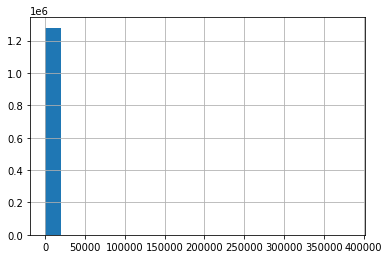

In [150]:
df_smb.tcp_payload_size.hist(bins=20)

In [26]:
sd_q3 = df_smb.session_duration.quantile(0.75)
sd_iqr = sd_q3-df_smb.session_duration.quantile(0.25)

sp_q3 = df_smb.session_packets.quantile(0.75)
sp_iqr = sp_q3 - df_smb.session_packets.quantile(0.25)

tpa_q3 =  df_smb.tcp_payload_avg.quantile(0.75)
tpq_iqr = tpa_q3 - df_smb.tcp_payload_avg.quantile(0.25)

tps_q3 = df_smb.tcp_payload_size.quantile(0.75)
tps_iqr = tps_q3 - df_smb.tcp_payload_size.quantile(0.25)

df_filter1_smb = df_smb[df_smb.session_duration>sd_q3+3*sd_iqr]
df_filter2_smb = df_filter1_smb[df_filter1_smb.session_packets>sp_q3+3*sp_iqr]
df_filter3_smb = df_filter2_smb[df_filter2_smb.tcp_payload_avg>tpa_q3+3*tpq_iqr]
df_filter4_smb = df_filter3_smb[df_filter3_smb.tcp_payload_size>tps_q3+3*tps_iqr]
print(sp_q3+3*sp_iqr,tps_q3+3*tps_iqr,tpa_q3+3*tpq_iqr,sd_q3+3*sd_iqr)
print(df_filter4_smb.session_packets.sum())
df_filter4_smb

42.0 1928.0 121.53846153846155 25.99714970588684
161109


,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
21075,1.578602e+09,"[1578601885.650866, 1578601888.647785, 1578601...",38.528332,127,16228.857143,16560.0,64233.0,2696.0,NaN,NaN,55533.0,445.0,125.0,0.0,46.0,0.0,4.0,138.204.74.42,210.242.149.46,101.0,101.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,71547,Brazil,Nonoai,Rio Grande do Sul,-27.369,-52.8759,rvsul.com.br,Rv Sul Telecom Ltda - Me,138.204.72.0/22,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,505.771654,NaN,NaN,NaN
62146,1.578651e+09,"[1578651275.237626, 1578651275.237861, 1578651...",90.204414,124,16300.875000,16944.0,106988.0,2496.0,NaN,NaN,46435.0,445.0,122.0,2.0,54.0,1.0,2.0,2.136.208.15,210.242.147.76,105.0,105.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb:ntlmssp,113898,Spain,Seville,Seville,37.3834,-5.9789,rima-tde.net,Telefonica de Espana Static IP,2.136.0.0/16,NaN,NaN,NaN,[6:wV08dAwTAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,862.806452,NaN,NaN,NaN
63147,1.578596e+09,"[1578596048.985823, 1578596048.986072, 1578596...",31.007938,117,16512.830508,16721.0,64370.0,2424.0,NaN,NaN,62185.0,445.0,116.0,0.0,51.0,0.0,4.0,201.46.29.168,210.242.149.26,111.0,111.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,71072,Brazil,São Paulo,Sao Paulo,-23.63,-46.6322,a85.com.br,America-NET Ltda.,201.46.16.0/20,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,550.170940,NaN,NaN,NaN
208463,1.578594e+09,"[1578593569.965064, 1578593569.966037, 1578593...",138.241287,158,16216.738462,17520.0,41620.0,3176.0,NaN,NaN,1972.0,445.0,154.0,2.0,73.0,3.0,2.0,104.244.180.25,210.242.148.111,105.0,105.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb:ntlmssp,50498,Puerto Rico,Bayamón,None,18.3986,-66.1557,libertypr.net,Liberty Cablevision of Puerto Rico,104.244.180.0/23,NaN,NaN,NaN,[6:wV08dAwTAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,263.417722,NaN,NaN,NaN
214423,1.578624e+09,"[1578624162.825473, 1578624162.825731, 1578624...",28.501152,94,63375.428571,64800.0,64096.0,1896.0,NaN,NaN,55422.0,445.0,93.0,0.0,49.0,0.0,2.0,117.2.167.233,210.242.149.50,114.0,114.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,69430,Vietnam,Hoi An,Tinh Quang Nam,15.8794,108.335,None,Viettel Group,117.0.0.0/14,NaN,NaN,NaN,[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,681.872340,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41437373,1.578670e+09,"[1578670493.379267, 1578670493.379624, 1578670...",33.629959,166,64856.104478,65535.0,95820.0,3336.0,NaN,NaN,2700.0,445.0,165.0,2.0,87.0,0.0,2.0,46.24.70.178,210.242.147.96,111.0,111.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb:ntlmssp,105130,Spain,Cartagena,Murcia,37.6051,-0.9862,comunitel.net,Vodafone Spain,46.24.64.0/21,NaN,NaN,NaN,[6:wV08dAwTAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,577.228916,NaN,NaN,NaN
41437374,1.578596e+09,"[1578596065.723275, 1578596065.723715, 1578596...",29.860952,148,65068.551724,65535.0,94724.0,2976.0,NaN,NaN,3766.0,445.0,147.0,2.0,79.0,0.0,2.0,46.24.70.178,210.242.148.115,111.0,111.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb:ntlmssp,103032,Spain,Cartagena,Murcia,37.6051,-0.9862,comunitel.net,Vodafone Spain,46.24.64.0/21,NaN,NaN,NaN,[6:wV08dAwTAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVI...,640.027027,NaN,NaN,NaN
41437375,1.578596e+09,"[1578596096.879874, 1578596096.880108, 1578596...",29.141880,150,65094.177419,65535.0,94640.0,30

In [118]:
df_filter4_smb.domain.value_counts().head(20)

comunitel.net            325
libertypr.net            101
rima-tde.net             100
vnpt.vn                   60
megared.net.mx            39
hinet.net                 24
otenet.gr                 17
viettel.vn                16
pldt.net                  11
actcorp.in                11
prod-infinitum.com.mx      9
totinternet.net            8
rr.com                     5
cantv.net                  5
vdc.vn                     5
uninet-ide.com.mx          5
airtelbroadband.in         5
com.co                     4
3bb.co.th                  4
totalplay.net              3
Name: domain, dtype: int64

161109

In [132]:
len(df_filter4_smb[df_filter4_smb.domain == 'totalplay.net'].ip_src.unique())

3

In [137]:
case121 = df[(df.ip_src=='113.189.231.122')]
case121.frame_protocols_max.value_counts()

eth:ethertype:ip:tcp                     280
eth:ethertype:ip:tcp:nbss:smb            155
eth:ethertype:ip:tcp:nbss:smb:smb:smb     10
Name: frame_protocols_max, dtype: int64

In [135]:
len(case121)

445

#### Case8
* telnet

In [27]:
df_fil2_telnet = df[df['frame_protocols_max'].str.contains('telnet')]
df_fil2_telnet = df_fil2_telnet[(df_fil2_telnet.domain != 'googlebot.com')&(df_fil2_telnet.isp!='Googlebot')]
print(len(df_fil2_telnet))

494


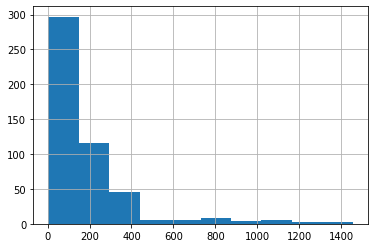

In [147]:
df_fil2_telnet.tcp_payload_size.hist()

In [28]:
df_fil2_telnet.tcp_payload_size.describe()

count     494.000000
mean      186.358300
std       235.834789
min         4.000000
25%        48.000000
50%       121.000000
75%       235.000000
max      1455.000000
Name: tcp_payload_size, dtype: float64

In [141]:
case_telnet = df[df.ip_src == '184.154.47.2']
case_telnet.frame_protocols_max.value_counts()

eth:ethertype:ip:tcp                         98
eth:ethertype:ip:tcp:ftp                     27
eth:ethertype:ip:tcp:telnet                  15
eth:ethertype:ip:icmp:ip:udp:ntp             12
eth:ethertype:ip:udp:ntp                     12
eth:ethertype:ip:tcp:pop:imf                  9
eth:ethertype:ip:tcp:imap                     8
eth:ethertype:ip:tcp:imap:ssl                 7
eth:ethertype:ip:udp:dns                      6
eth:ethertype:ip:tcp:smtp                     6
eth:ethertype:ip:icmp:ip:udp:dns              6
eth:ethertype:ip:tcp:rtsp                     5
eth:ethertype:ip:tcp:http:data-text-lines     3
eth:ethertype:ip:tcp:http:data                3
eth:ethertype:ip:tcp:ssl                      3
eth:ethertype:ip:tcp:nbss                     2
eth:ethertype:ip:tcp:imap:data                2
eth:ethertype:ip:tcp:http                     2
eth:ethertype:ip:tcp:data                     1
Name: frame_protocols_max, dtype: int64

#### TDS
Case 13

In [45]:
df_fil2_tds = df[df['frame_protocols_max'].str.contains('tds')]
df_fil2_tds = df_fil2_tds[(df_fil2_tds.domain != 'googlebot.com')&(df_fil2_tds.isp!='Googlebot')]
df_fil2_tds

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
295,1.578633e+09,"[1578632702.356261, 1578632702.356419, 1578632...",0.084249,6,46290.666667,65340.0,198.0,136.0,NaN,NaN,5994.0,1433.0,5.0,0.0,1.0,1.0,2.0,1.55.108.5,210.242.145.101,108.000000,108.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,552,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,1.52.0.0/14,NaN,NaN,NaN,[12:MZJlusxTvuw3s5vYTVqAgfY1ifYNByVHA+Oi56ikJ:...,33.000000,NaN,NaN,NaN
296,1.578636e+09,"[1578635662.776086, 1578635662.776279, 1578635...",0.083586,6,13862.666667,16698.0,198.0,144.0,NaN,NaN,6122.0,1433.0,5.0,0.0,1.0,1.0,2.0,1.55.108.5,210.242.145.101,108.000000,108.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,558,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,1.52.0.0/14,NaN,NaN,NaN,[12:MZJlusxTvuw3s5C5tVJJIWs6+1VLA+Oi56ikJ:MZ2s...,33.000000,NaN,NaN,NaN
297,1.578635e+09,"[1578635450.296956, 1578635450.297343, 1578635...",0.176785,10,14996.800000,16698.0,172.0,224.0,NaN,NaN,6647.0,1433.0,6.0,2.0,1.0,3.0,2.0,1.55.108.5,210.242.145.101,108.000000,108.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,760,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,1.52.0.0/14,NaN,NaN,NaN,[12:Mu9zusnMXTv0OBv8lQTdqXW1pfMZE6QhA+Oi56ikv3...,17.200000,NaN,NaN,NaN
298,1.578637e+09,"[1578636992.957193, 1578636992.957399, 1578636...",0.080466,7,13862.666667,16698.0,174.0,164.0,NaN,NaN,8979.0,1433.0,5.0,0.0,1.0,2.0,2.0,1.55.108.5,210.242.145.101,108.333333,109.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,594,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,1.52.0.0/14,NaN,NaN,NaN,[12:MaL9usnMXTvh+O+oiTtwXWTddAhA+Oi56ikv3:MaUs...,24.857143,NaN,NaN,NaN
299,1.578635e+09,"[1578634911.347904, 1578634911.348289, 1578634...",0.088010,6,46290.666667,65340.0,194.0,136.0,NaN,NaN,10528.0,1433.0,5.0,0.0,1.0,1.0,2.0,1.55.108.5,210.242.145.101,108.000000,108.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,548,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,1.52.0.0/14,NaN,NaN,NaN,[12:MdjusxTvuw36IGOaBV7+htb0VZt38A+Oi56ikJ:Mos...,32.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41508060,1.578660e+09,"[1578659860.472968, 1578659860.473331, 1578659...",0.394240,6,13770.666667,16560.0,194.0,144.0,NaN,NaN,53116.0,1433.0,5.0,0.0,1.0,1.0,2.0,95.58.134.110,210.242.149.74,114.000000,114.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,554,Kazakhstan,Pavlodar,Pavlodar Region,52.274,77.0044,telecom.kz,JSC Kazakhtelecom,95.58.132.0/22,NaN,NaN,NaN,[12:Mdji+xTvuw3zLoytVRyr/pYEe1zLSUIVZ9ZA+Oi5ac...,32.333333,NaN,NaN,NaN
41508061,1.578660e+09,"[1578659888.164874, 1578659888.165081, 1578659...",0.387610,6,13770.666667,16560.0,196.0,144.0,NaN,NaN,56791.0,1433.0,5.0,0.0,1.0,1.0,2.0,95.58.134.110,210.242.149.74,114.000000,114.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,556,Kazakhstan,Pavlodar,Pavlodar Region,52.274,77.0044,telecom.kz,JSC Kazakhtelecom,95.58.132.0/22,NaN,NaN,NaN,[12:M5i+xTvuw3UsHf1At999999999RjX9AZA+Oi5aclMJ...,32.666667,NaN,NaN,NaN
41508114,1.578622e+09,"[1578621770.33071, 1578621770.33098, 157862177...",0.219120,6,3072.666667,8192.0,41.0,144.0,NaN,NaN,63762.0,1433.0,5.0,0.0,1.0,1.0,2.0,98.102.230.62,210.242.146.101,112.000000,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,401,United States,Logan,Ohio,39.537

In [88]:
df_fil2_tds.tcp_payload_size.describe()

count    1.567368e+07
mean     2.605370e+02
std      2.580208e+03
min      2.400000e+01
25%      1.920000e+02
50%      1.940000e+02
75%      2.560000e+02
max      1.126738e+06
Name: tcp_payload_size, dtype: float64

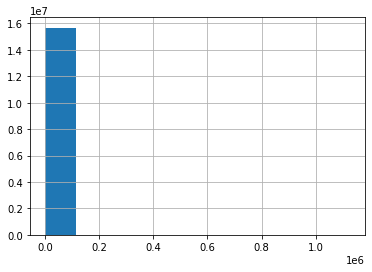

In [47]:
df_fil2_tds.tcp_payload_size.hist()

In [46]:
sd_q3 = df_fil2_tds.session_duration.quantile(0.75)
sd_iqr = sd_q3-df_fil2_tds.session_duration.quantile(0.25)

sp_q3 = df_fil2_tds.session_packets.quantile(0.75)
sp_iqr = sp_q3 - df_fil2_tds.session_packets.quantile(0.25)

tpa_q3 =  df_fil2_tds.tcp_payload_avg.quantile(0.75)
tpq_iqr = tpa_q3 - df_fil2_tds.tcp_payload_avg.quantile(0.25)

tps_q3 = df_fil2_tds.tcp_payload_size.quantile(0.75)
tps_iqr = tps_q3 - df_fil2_tds.tcp_payload_size.quantile(0.25)

df_filter1_tds = df_fil2_tds[df_fil2_tds.session_duration>sd_q3+3*sd_iqr]
df_filter2_tds = df_filter1_tds[df_filter1_tds.session_packets>sp_q3+3*sp_iqr]
df_filter3_tds = df_filter2_tds[df_filter2_tds.tcp_payload_avg>tpa_q3+3*tpq_iqr]
df_filter4_tds = df_filter3_tds[df_filter3_tds.tcp_payload_size>tps_q3+3*tps_iqr]
print(sp_q3+3*sp_iqr,tps_q3+3*tps_iqr,tpa_q3+3*tpq_iqr,sd_q3+3*sd_iqr)
print(df_filter4_tds.session_packets.sum())
df_filter4_tds

14.0 448.0 41.52380952380951 2.891646921634674
167312


,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
3224,1.578643e+09,"[1578642656.752276, 1578642656.752513, 1578642...",33.705280,15,52699.800000,64860.0,858.0,356.0,NaN,NaN,2899.0,1433.0,14.0,0.0,5.0,1.0,4.0,103.29.119.122,210.242.148.91,114.0,114.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,1730,India,Boisar,Maharashtra,19.8036,72.756,keznews.com,Digital Network Associates Pvt,103.29.116.0/22,NaN,NaN,NaN,[12:M5J4xTvuw3Us1qVZ+DZ4fo6c7A+Oi5sBdJ:ME9uw30...,57.200000,NaN,NaN,NaN
8526,1.578651e+09,"[1578651196.814305, 1578651196.81445, 15786511...",4.703069,16,15437.875000,16473.0,960.0,344.0,NaN,NaN,38360.0,1433.0,9.0,1.0,5.0,6.0,2.0,116.98.142.146,210.242.145.66,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,1890,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:M4YxTvuw36GmRpG5avYv/VZH8A+Oi56iESJ:M99uw3...,60.000000,NaN,NaN,NaN
9244,1.578648e+09,"[1578648486.38279, 1578648486.382983, 15786484...",7.880368,19,15836.000000,16473.0,1274.0,476.0,NaN,NaN,47255.0,1433.0,17.0,1.0,7.0,1.0,5.0,116.98.142.146,210.242.148.89,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,2408,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MLlYnMXTvcAtFzlnWcfkpk/if4GhvuCCshA+Oi5sMb...,67.052632,NaN,NaN,NaN
9253,1.578651e+09,"[1578650878.510688, 1578650878.510881, 1578650...",11.369600,18,15552.888889,16473.0,1092.0,384.0,NaN,NaN,33421.0,1433.0,10.0,1.0,6.0,7.0,2.0,116.98.142.146,210.242.149.107,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds,2136,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MLlYnMXTvctV9rV94lnWcfkpk/if4Gvmm1TalhA+Oi...,60.666667,NaN,NaN,NaN
9260,1.578651e+09,"[1578651298.203702, 1578651298.203866, 1578651...",10.642828,19,13997.600000,16473.0,1164.0,404.0,NaN,NaN,35316.0,1433.0,11.0,1.0,6.0,8.0,2.0,116.98.142.146,210.242.149.107,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,2262,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MdjYxTvuw36IGKdIkdPWgFm1NJxpjZA+Oi5acSvJ:M...,61.263158,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41429874,1.578638e+09,"[1578638147.851497, 1578638147.851793, 1578638...",10.317762,16,14292.090909,16560.0,1044.0,392.0,NaN,NaN,10324.0,1433.0,15.0,0.0,6.0,1.0,4.0,42.119.231.95,210.242.145.107,109.0,109.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,1986,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,42.116.0.0/14,NaN,NaN,NaN,[12:MdjrxTvuw36IHHuqfYXTHVtA+Oi56iSvJ:M99uw3VH...,65.250000,NaN,NaN,NaN
41430294,1.578638e+09,"[1578638102.817125, 1578638102.817277, 1578638...",7.192462,16,14292.090909,16560.0,1054.0,392.0,NaN,NaN,42915.0,1433.0,15.0,0.0,6.0,1.0,4.0,42.119.231.95,210.242.145.76,109.0,109.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,1996,Vietnam,Hanoi,Hanoi,21.0313,105.8516,None,FPT Telecom Company,42.116.0.0/14,NaN,NaN,NaN,[12:M5rxTvuw3UsGOWA13htGwm1NSQ3VhQLzA+Oi56ilEn...,65.875000,NaN,NaN,NaN
41431046,1.578638e+09,"[1578637688.080146, 1578637688.080337, 1578637...",10.667312,17,14482.666667,16560.0,960.0,436.0,NaN,NaN,26391.0,1433.0,16.0,1.0,5.0,1.0,5.0,42.119.231.95,210.242.148.99,109.0,109.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,1980,Vietnam,Hanoi,Hanoi,21.0313,105.

In [57]:
df_filter4_tds.domain.value_counts()#.index

Index(['viettel.vn', 'cantv.net', 'airtelbroadband.in', 'corbina.ru',
       'hinet.net', '123-tataidc.co.in', 'tedata.net', 'asianet.co.th',
       'linkone.co.kr', 'turbonex.com.br', 'telbrax.net.br', 'axtel.net',
       'actcorp.in', 'webflash.net.br', 'dss-group.net', 'br27.com.br',
       'multi.net.pk', 'keznews.com', 'nexlinx.net.pk', 'copel.net',
       'sikkanet.com', 'telkom.net.id', 'bsnl.in', 'mtnl.net.in',
       '182-airtel.com', '163data.com.cn', 'cyberwaybd.net', 'qwertynet.ru',
       'eflydns.net', 'sl-reverse.com', 'vnpt.vn', 'prod-infinitum.com.mx',
       'maralexprovedor.com.br', 'megared.net.mx', 'totalplay.net',
       'permonline.ru', 'argeweb.nl', 'gtt.co.gy', 'adsl-pool.sx.cn',
       'internet.sx.cn', 'axtel.net.mx', 'tie.cl', 'ctbctelecom.com.br',
       'colocrossing.com', 'btopenworld.com'],
      dtype='object')

In [58]:
for dom in df_filter4_tds.domain.value_counts().index:
    print(dom,len(df_filter4_tds[df_filter4_tds.domain == dom].ip_src.unique()))

viettel.vn 1
cantv.net 7
airtelbroadband.in 2
corbina.ru 2
hinet.net 9
123-tataidc.co.in 1
tedata.net 2
asianet.co.th 1
linkone.co.kr 1
turbonex.com.br 1
telbrax.net.br 1
axtel.net 1
actcorp.in 3
webflash.net.br 1
dss-group.net 1
br27.com.br 1
multi.net.pk 2
keznews.com 1
nexlinx.net.pk 1
copel.net 1
sikkanet.com 1
telkom.net.id 5
bsnl.in 1
mtnl.net.in 1
182-airtel.com 1
163data.com.cn 5
cyberwaybd.net 4
qwertynet.ru 1
eflydns.net 2
sl-reverse.com 1
vnpt.vn 1
prod-infinitum.com.mx 1
maralexprovedor.com.br 1
megared.net.mx 1
totalplay.net 1
permonline.ru 1
argeweb.nl 1
gtt.co.gy 1
adsl-pool.sx.cn 1
internet.sx.cn 1
axtel.net.mx 1
tie.cl 1
ctbctelecom.com.br 1
colocrossing.com 1
btopenworld.com 1


In [60]:
df_filter4_tds.ip_src.value_counts()

180.251.178.241    676
203.129.208.130    654
58.171.226.38      608
218.201.77.76      600
116.98.142.146     581
                  ... 
43.246.202.244       1
113.118.189.83       1
210.56.60.10         1
180.138.117.166      1
210.56.60.135        1
Name: ip_src, Length: 210, dtype: int64

In [64]:
df_filter4_tds.isp.value_counts()

PT Telkom Indonesia                           933
Viettel Group                                 727
Software Technology Parks of India            654
China Mobile Guangdong                        637
Telstra Internet                              608
                                             ... 
BT                                              1
Hangzhou Alibaba Advertising Co.,Ltd.           1
Vietnam Posts And Telecommunications Group      1
Pontenet Teleinformática Ltda.                  1
Capitalonline Data Service Co.,LTD              1
Name: isp, Length: 101, dtype: int64

In [67]:
case13_ips = df_filter4_tds[df_filter4_tds.domain == 'viettel.vn'].frame_time_list.tolist()
case13_ips = [list(x) for x in case13_ips]
pickle.dump(obj=case13_ips,file=open(pickle_dir+'case13_new.pkl','wb'))
len(case13_ips)

581

case13-1

In [72]:
case13_1 = df[(df.ip_src == '116.98.142.146')&(~df.frame_protocols_max.str.contains('tds'))&
              (df.session_duration>0.1)&(df.session_packets>1)]
case13_1 = case13_1[(case13_1.tcp_payload_avg>0)|(case13_1.icmp_payload_avg>0)|
                    (case13_1.udp_payload_avg>0)]
case13_1

,frame_time,frame_time_list,session_duration,session_packets,tcp_window_size_value_avg,tcp_window_size_value_max,tcp_payload_size,tcp_hdr_len_sum,icmp_length_sum,icmp_length_original_datagram_sum,tcp_srcport,tcp_dstport,tcp_flags_ack,tcp_flags_fin,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,ip_src,ip_dst,ip_ttl_avg,ip_ttl_max,ip_proto,frame_protocols_common,frame_protocols_max,frame_len_sum,country,city,subdivisions,latitude,longitude,domain,isp,network,udp_length_sum,udp_srcport,udp_dstport,tcp_payload_list,tcp_payload_avg,udp_payload_size,udp_payload_avg,icmp_payload_avg
9255,1.578652e+09,"[1578652134.131944, 1578652134.132174, 1578652...",0.536671,7,14402.75,16473.0,194.0,164.0,NaN,NaN,34525.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.149.107,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,608,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MdjYxTvuw36IjCyCCI2dVA3vCA+Oi5acSvJ:MC9uw3...,27.714286,NaN,NaN,NaN
422381,1.578652e+09,"[1578652092.221125, 1578652092.221348, 1578652...",3.152696,7,14402.75,16473.0,202.0,164.0,NaN,NaN,38924.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.149.125,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,616,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:M+1YxTvuw3+fGyu6LWfsrWfYE4fosEzeAhpA+Oi5ac...,28.857143,NaN,NaN,NaN
422385,1.578651e+09,"[1578651109.360266, 1578651109.360478, 1578651...",0.545166,7,14402.75,16473.0,196.0,164.0,NaN,NaN,40733.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.149.125,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,610,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:M5YxTvuw3zLwA6t9999999GK7QA+Oi5acmXJ:M29uw...,28.000000,NaN,NaN,NaN
631118,1.578652e+09,"[1578651596.575314, 1578651596.575544, 1578651...",0.538838,7,50417.00,64492.0,194.0,156.0,NaN,NaN,45428.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.147.100,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,602,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MdjYxTvuw36IIHlVK3fYGfYTESxMKDpA+Oi5sa/nJ:...,27.714286,NaN,NaN,NaN
839806,1.578650e+09,"[1578650370.005655, 1578650370.005894, 1578650...",0.511731,7,14402.75,16473.0,192.0,164.0,NaN,NaN,39594.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.147.71,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,606,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:M4YxTvuw36GmRpbs0V0Q3htG0IYxSsCoZA+Oi5salj...,27.428571,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39225611,1.578652e+09,"[1578651676.32506, 1578651676.325224, 15786516...",0.525416,7,14402.75,16473.0,192.0,164.0,NaN,NaN,43491.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.148.78,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,606,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:M4YxTvuw36GmRpUC5+wYhtBEUpAA+Oi5slgJ:M99uw...,27.428571,NaN,NaN,NaN
40051932,1.578651e+09,"[1578650557.88615, 1578650557.88642, 157865055...",0.435311,7,14402.75,16473.0,194.0,164.0,NaN,NaN,36993.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.149.107,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,608,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MdjYxTvuw36IjpxbxbxbxbxbxbxORUIZA+Oi5acSvJ...,27.714286,NaN,NaN,NaN
40260381,1.578650e+09,"[1578650361.227807, 1578650361.228034, 1578650...",0.483543,7,14402.75,16473.0,194.0,164.0,NaN,NaN,35269.0,1433.0,5.0,1.0,1.0,1.0,2.0,116.98.142.146,210.242.147.100,112.0,112.0,6,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,608,Vietnam,None,None,16.0,106.0,viettel.vn,Viettel Group,116.98.128.0/17,NaN,NaN,NaN,[12:MdjYxTvuw36I1qAiSeCcZlUZA+Oi5sa/nJ:MC9uw3q...,27.714286,NaN,NaN,NaN
40678738,1.578652e+09,"[1578651519.097317, 157865

In [75]:
case13_1.udp_dstport.value_counts()

Series([], Name: udp_dstport, dtype: int64)

In [73]:
case13_1_time = case13_1.frame_time_list.tolist()
case13_1_time = [list(x) for x in case13_1_time]
print(len(case13_1_time))
pickle.dump(obj=case13_1_time,file=open(pickle_dir+"case13-1_new.pkl",'wb'))

207


case13-2
* 其他集團是不是也是跟case13一樣的相同攻擊?

In [77]:
case132_ips = df_filter4_tds[df_filter4_tds.domain == 'cantv.net'].frame_time_list.tolist()
case132_ips = [list(x) for x in case132_ips]
pickle.dump(obj=case132_ips,file=open(pickle_dir+'case132_1.pkl','wb'))
print(len(case132_ips))

case132_ips = df_filter4_tds[df_filter4_tds.domain == 'airtelbroadband.in'].frame_time_list.tolist()
case132_ips = [list(x) for x in case132_ips]
pickle.dump(obj=case132_ips,file=open(pickle_dir+'case132_2.pkl','wb'))
print(len(case132_ips))

case132_ips = df_filter4_tds[df_filter4_tds.domain == 'hinet.net'].frame_time_list.tolist()
case132_ips = [list(x) for x in case132_ips]
pickle.dump(obj=case132_ips,file=open(pickle_dir+'case132_3.pkl','wb'))
print(len(case132_ips))

421
373
335


## SSDEEP try

In [29]:
hash1 = ssdeep.hash('Also called fuzzy hashes, Ctph can match inputs that have homologies.')
hash1

'3:AXGBicFlgVNhBGcL6wCrFQEv:AXGHsNhxLsr2C'

In [43]:
ssdeep??

In [85]:
hash2 = ssdeep.hash('YYY cant"t match inputs that have homologies. Ctph can match inputs that have homologies.Ctph can match inputs that have homologies.Ctph can match inputs that have homologs.')
hash2

'3:OVd04jL6wCrFQEYhBGcL6wCrFQEaNFHBGcL6wCrFQEaNFHBGcL6wCrFQEh:i04jLsr2xxLsr2hXxLsr2hXxLsr2I'

In [86]:
ssdeep.compare(hash1, hash2)

24